In [7]:
using CodecBzip2
using RData
using Distributions
using Statistics
using SpecialFunctions
using Plots
using ProgressMeter
using CSV
using DataFrames
using LinearAlgebra
using Random 
using StatsBase
using ProgressMeter
using StatsPlots
using SynthControl
using Dates
using LogExpFunctions

In [8]:
function SoftmaxLSE(x::Array{Float64})
    c = maximum(x)
    LSE = c + log(sum(exp.(x .- c)))
    return exp.(x .- LSE)
end

SoftmaxLSE (generic function with 1 method)

## Gibbs Sampler

In [9]:
mutable struct gibbsSampler
    I::Int64
    T::Int64
    I_T::Array{Float64, 2}
    σ::Float64
    α::Array{Float64}
    β::Float64
    θ::Float64
    D::Array{Float64}
    C::Float64
    Y::Array{Float64}
    X::Array{Float64, 2}
end

function initGibbs(I::Int64, T::Int64, θ::Float64, β::Float64, α::Array{Float64})
    Y = zeros(T)
    C = 0.0
    σ = 0.0
    D = zeros(I)
    X = zeros(I, T)
    I_T = diagm(ones(T))
    return gibbsSampler(I, T, I_T, σ, α, β, θ, D, C, Y, X)
end

initGibbs (generic function with 1 method)

In [10]:
function sampleD!(gs::gibbsSampler)
    gs.D = rand(Dirichlet(gs.α))
    return gs.D
end

function sampleC!(gs::gibbsSampler)
    gs.C = rand(Categorical(gs.D))
    return gs.C
end

function sampleσ!(gs::gibbsSampler)
    gs.σ = rand(InverseGamma(gs.θ, gs.β))
    return gs.σ
end

function sampleY!(gs::gibbsSampler)
    gs.Y = rand(MvNormal(gs.X[Int64(gs.C), :], gs.σ .* gs.I_T))
    return gs.Y
end

function sampleY(gs::gibbsSampler, X::Array{Float64, 2}, T::Int64)
    return rand(MvNormal(X[Int64(gs.C), :], gs.σ .* diagm(ones(T))))
end

function samplePrior!(gs::gibbsSampler)
    sampleD!(gs)
    sampleC!(gs)
    sampleσ!(gs)
    sampleY!(gs)
end

samplePrior! (generic function with 1 method)

In [25]:
function updateD!(gs::gibbsSampler)
    param = deepcopy(gs.α)
    param[Int64(gs.C)] += 1.0
    gs.D = rand(Dirichlet(param))
    return gs.D
end

function updateC!(gs::gibbsSampler)
    probs = zeros(gs.I)
    for i ∈ 1:gs.I
        N = 0.0
        for t ∈ 1:gs.T
            N += -0.5 * log(2*π) - 0.5*log(gs.σ) - 0.5 * 1.0/gs.σ * (gs.Y[t] - gs.X[i, t])^2
        end
        probs[i] = N - log(gs.D[i] + 1e-8)
    end
    newProbs = SoftmaxLSE(probs)
    gs.C = rand(Categorical(newProbs ./sum(newProbs)))
    return gs.C
end

function updateσ!(gs::gibbsSampler)
    shape = gs.θ + 0.5*gs.T
    rate = gs.β
    for t ∈ 1:gs.T
        rate += ((gs.Y[t] - gs.X[Int64(gs.C), t])^2) / 2.0
    end
    gs.σ = rand(InverseGamma(shape, rate))
    return gs.σ
end

function updateGibbs!(gs::gibbsSampler)
    updateC!(gs)
    updateD!(gs)
    updateσ!(gs)
    return gs
end


updateGibbs! (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


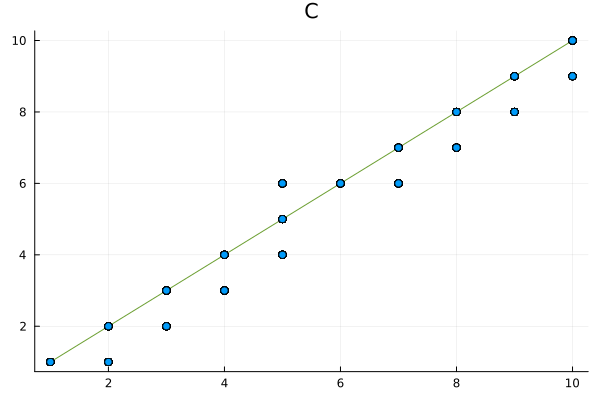

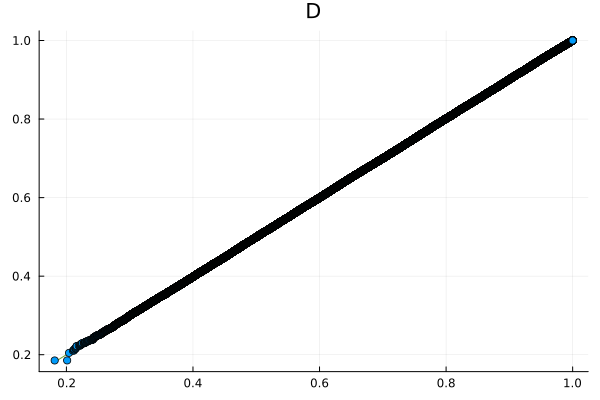

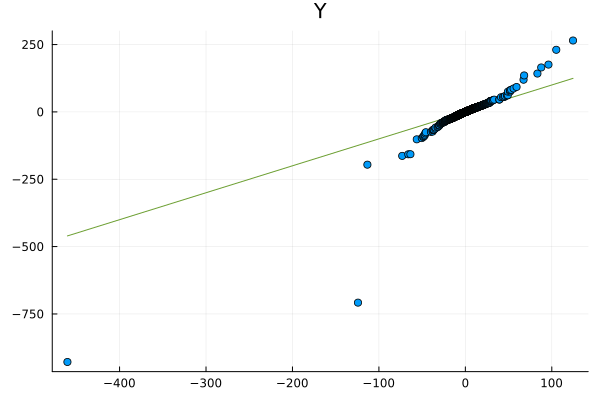

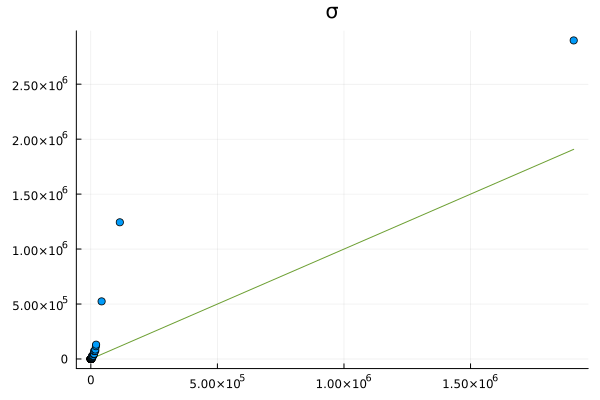

In [28]:
I = 10
T = 2
α = 0.1 .* ones(I)
θ = 1.0
β = 1.0
numItr = 100000

gs = initGibbs(I, T, θ, β, α)


gs.X = rand(Normal(), size(gs.X))

statC = zeros(2, numItr)
statD = zeros(2, numItr)
statσ = zeros(2, numItr)

statY = zeros(2, numItr)



@showprogress for i ∈ 1:numItr
    samplePrior!(gs)
    statC[1, i] = mean(gs.C)
    statσ[1, i] = mean(gs.σ)
    statD[1, i] = maximum(gs.D)
    statY[1, i] = mean(gs.Y)
end
@showprogress for i ∈ 1:numItr
    updateGibbs!(gs)
    sampleY!(gs)
end
@showprogress for i ∈ 1:numItr
    updateGibbs!(gs)
    sampleY!(gs)

    statC[2, i] = mean(gs.C)
    statσ[2, i] = mean(gs.σ)
    statD[2, i] = maximum(gs.D)
    statY[2, i] = mean(gs.Y)
end

display(qqplot(statC[1,:], statC[2,:], title="C", fmt=:png))
display(qqplot(statD[1,:], statD[2,:], title="D", fmt=:png))
display(qqplot(statY[1,:], statY[2,:], title="Y", fmt=:png))
display(qqplot(statσ[1,:], statσ[2,:], title="σ", fmt=:png))

## California Smoking Data

In [29]:
data = load("smoking.rda")["smoking"]
numStates = 39
numYears = 31
# California is state 3 and the intervention happened in 1989
T = numYears
I = numStates
obsT = 19

X = zeros(I-1, T)
Y = zeros(T)
YObs = zeros(T)
for row ∈ eachrow(data)
    if row["state"] == 3
        Y[Int64(row["year"] - 1969.0)] = row["cigsale"] 
        YObs[Int64(row["year"] - 1969.0)] = row["cigsale"]
    elseif row["state"] < 3
        X[Int64(row["state"]), Int64(row["year"] - 1969.0)] = row["cigsale"] 
    elseif row["state"] > 3
        X[Int64(row["state"])-1, Int64(row["year"] - 1969.0)] = row["cigsale"] 
    end
end


In [30]:
numItr = 100000

α = 1/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

gs = initGibbs(I-1, obsT, θ, β, α)

samplePrior!(gs)

gs.Y = deepcopy(Y[1:obsT])
gs.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(gs)
end

thin = 1

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(gs)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(gs.C)
        sampleD[div(i,thin), :] = deepcopy(gs.D)
        Ysamples[div(i,thin), :] = sampleY(gs, X, T)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05
Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


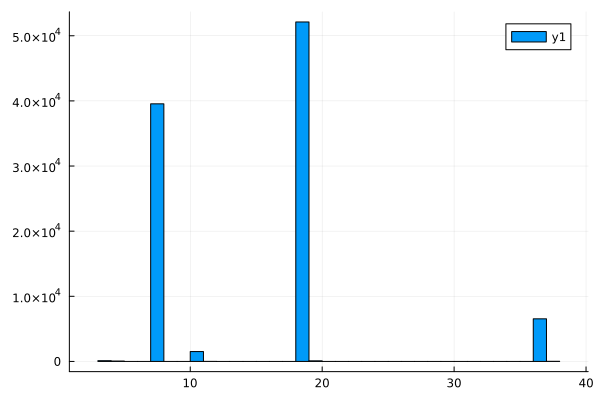

In [31]:
display(histogram(sampleC, bins=I-1))

predY = mean(Ysamples, dims=1)'
errUp = zeros(T)
errDown = zeros(T)
for t ∈ 1:T
    errUp[t] = quantile(Ysamples[:, t], 0.75)
    errDown[t] =  quantile(Ysamples[:, t], 0.25)
end

In [32]:
#Standard California Synthetic Control
df = load_smoking()
panel = load_smoking_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-8.44, -9.207, -12.633, -13.727, -17.531, -22.047, -22.857, -23.996, -26.258, -23.341, -27.522, -26.598]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: 3
    Number of untreated units: 38
    First treatment period: 1989
    Number of pretreatment periods: 19
    Number of treatment periods: 12


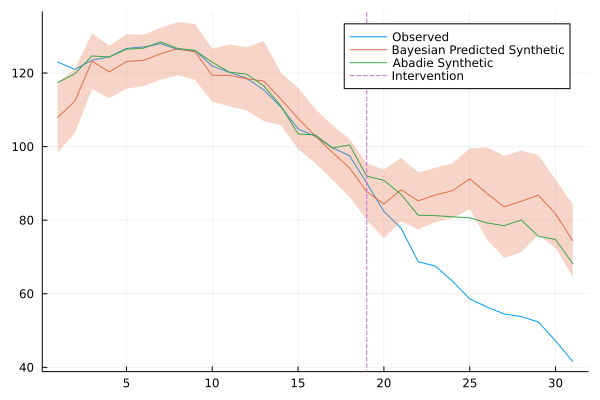

In [33]:
plot(YObs, label="Observed")
#plot!(sum(sampleD[6, :] .* X, dims=1)', label="Single Sample Bayesian Synthetic")
plot!(predY, ribbon=errUp - errDown, fillalpha=.3, label="Bayesian Predicted Synthetic")

plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([19], label="Intervention", seriestype = :vline, line=:dash)

## Basque

In [34]:
# Basque is region 17 and the intervention happened in 1975 or timestep 22
df = load_basque()

I = 18
T = 43
ObsT = 21

X = zeros(I-1, T)
Y = zeros(T)
for i ∈ eachrow(df)
    if i["regionno"] == 17
        Y[i["year"]-1955+1] = i["gdpcap"]
    elseif i["regionno"] < 17 
        X[i["regionno"], i["year"]-1955+1] = i["gdpcap"]
    elseif i["regionno"] > 17 
        X[i["regionno"]-1, i["year"]-1955+1] = i["gdpcap"]
    end
end


In [35]:
numItr = 100000

α = 1.0/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

gs = initGibbs(I-1, obsT, θ, β, α)
samplePrior!(gs)
gs.Y = deepcopy(Y[1:obsT])
gs.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(gs)
end

thin = 1#50

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(gs)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(gs.C)
        sampleD[div(i,thin), :] = deepcopy(gs.D)
        Ysamples[div(i,thin), :] = sampleY(gs, X, T)
    end
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


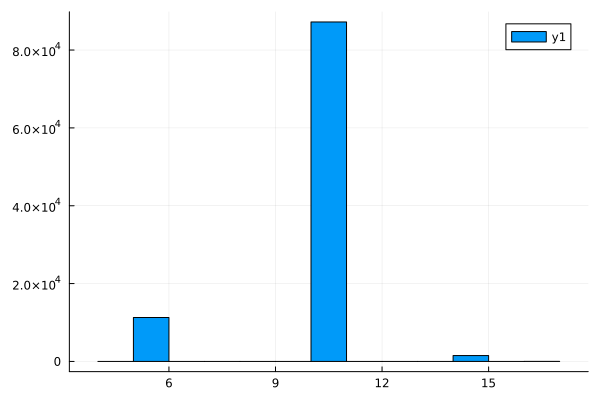

In [36]:
display(histogram(sampleC, bins=I-1))

predY = mean(Ysamples, dims=1)'
errUp = zeros(T)
errDown = zeros(T)
for t ∈ 1:T
    errUp[t] = quantile(Ysamples[:, t], 0.75)
    errDown[t] =  quantile(Ysamples[:, t], 0.25)
end

In [37]:
panel = load_basque_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-0.12, -0.197, -0.3, -0.402, -0.221, -0.047, -0.187, -0.321, -0.534, -0.643  …  -1.457, -1.445, -1.365, -1.321, -1.291, -1.269, -1.263, -1.108, -1.08, -1.012]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: Basque Country (Pais Vasco)
    Number of untreated units: 17
    First treatment period: 1970
    Number of pretreatment periods: 15
    Number of treatment periods: 28


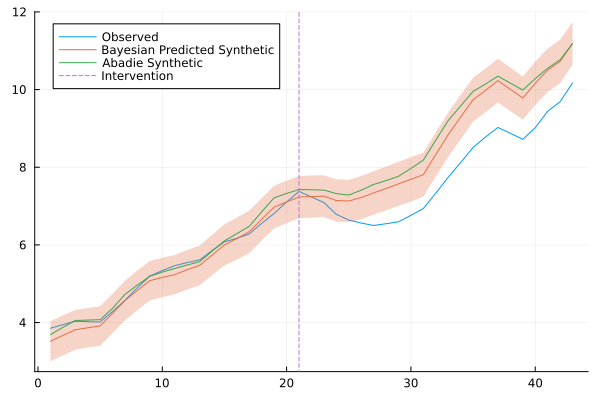

In [38]:
plot(Y, label="Observed")
#plot!(sum(mean(sampleD, dims=1)' .* X, dims=1)', label="Bayesian Synthetic")
#plot!(sum(sampleD[6, :] .* X, dims=1)', label="Single Sample Bayesian Synthetic")
plot!(predY, ribbon=errUp - errDown, fillalpha=.3, label="Bayesian Predicted Synthetic")

plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([21], label="Intervention", seriestype = :vline, line=:dash)

## Germany Data

In [39]:
# Germany is region 7 and the intervention happened in 1990 or timestep 30
df = load_germany()

I = 18
T = 44
ObsT = 30

X = zeros(I-1, T)
Y = zeros(T)

for i ∈ eachrow(df)
    if i["index"] == 12
        i["index"] = 11
    end
    if i["index"] == 14
        i["index"] = 12
    end
    if i["index"] == 16
        i["index"] = 13
    end
    if i["index"] == 18
        i["index"] = 14
    end
    if i["index"] == 19
        i["index"] = 15
    end
    if i["index"] == 20
        i["index"] = 16
    end
    if i["index"] == 21
        i["index"] = 17
    end
    if i["index"] == 7
        Y[i["year"]-1960+1] = i["gdp"]
    elseif i["index"] < 7
        X[i["index"], i["year"]-1960+1] = i["gdp"]
    elseif i["index"] > 7
        X[i["index"]-1, i["year"]-1960+1] = i["gdp"]
    end
end


In [40]:
numItr = 100000

α = 1.0/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

gs = initGibbs(I-1, obsT, θ, β, α)

samplePrior!(gs)
gs.Y = deepcopy(Y[1:obsT])
gs.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(gs)
end

thin = 1#50

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(gs)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(gs.C)
        sampleD[div(i,thin), :] = deepcopy(gs.D)
        Ysamples[div(i,thin), :] = sampleY(gs, X, T)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


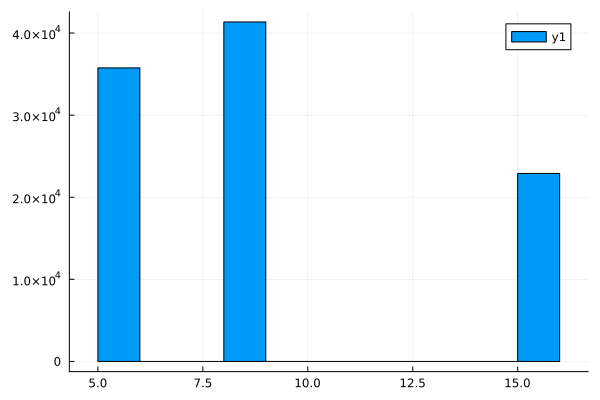

In [41]:
display(histogram(sampleC, bins=I-1))

predY = mean(Ysamples, dims=1)'
errUp = zeros(T)
errDown = zeros(T)
for t ∈ 1:T
    errUp[t] = quantile(Ysamples[:, t], 0.75)
    errDown[t] =  quantile(Ysamples[:, t], 0.25)
end

In [42]:
panel = load_germany_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)

┌ Warning: Failed to achieve finite new evaluation point, using alpha=0
└ @ LineSearches C:\Users\nihar\.julia\packages\LineSearches\G1LRk\src\hagerzhang.jl:148



Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [351.759, 769.549, 585.335, -166.047, -630.087, -784.339, -1012.161, -1626.912, -1803.083, -2083.991, -2657.6, -2900.057, -3064.183, -3532.909]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: West Germany
    Number of untreated units: 16
    First treatment period: 1990
    Number of pretreatment periods: 30
    Number of treatment periods: 14


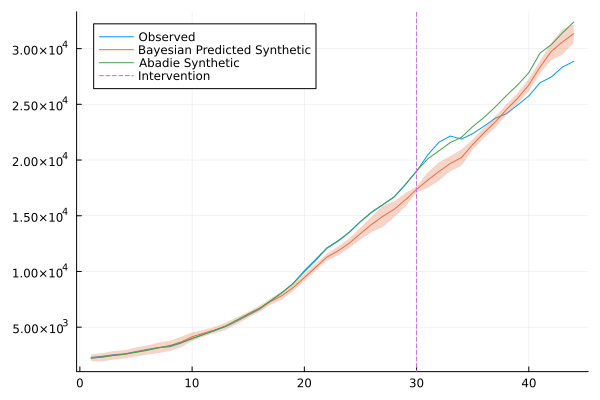

In [43]:
plot(Y, label="Observed")
#plot!(sum(mean(sampleD, dims=1)' .* X, dims=1)', label="Bayesian Synthetic")
#plot!(sum(sampleD[6, :] .* X, dims=1)', label="Single Sample Bayesian Synthetic")
plot!(predY, ribbon=errUp - errDown, fillalpha=.3, label="Bayesian Predicted Synthetic")

plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([ObsT], label="Intervention", seriestype = :vline, line=:dash)

## Brexit Data

In [44]:
#Standard Brexit Synthetic Control, Intervention happeed at timestep 31, Britain is country 22
df = load_brexit()

I = 23
T = 39
ObsT = 30

X = zeros(I-1, T)
Y = zeros(T)

IMap = unique(df[!, "country"])
TMap = unique(df[!, "quarter"])

for i ∈ eachrow(df)
    state = findfirst(==(i["country"]), IMap)
    time = findfirst(==(i["quarter"]), TMap)
    if state == 22
        Y[time] = i["realgdp"]
    elseif state < 22
        X[state, time] = i["realgdp"]
    elseif state > 22
        X[state-1, time] = i["realgdp"]
    end
end


In [45]:
numItr = 1000000

α = 1.0/(I-1.0) .* ones(I-1)
θ = 1.0
β = 1.0

gs = initGibbs(I-1, obsT, θ, β, α)

samplePrior!(gs)
gs.Y = deepcopy(Y[1:obsT])
gs.X = deepcopy(X[:, 1:obsT])

sampleC = zeros(numItr)
sampleD = zeros(numItr, I-1)
Ysamples = zeros(numItr, T)

@showprogress for i ∈ 1:numItr
    updateGibbs!(gs)
end

thin = 1#50

@showprogress for i ∈ 1:numItr*thin
    updateGibbs!(gs)
    if i % thin == 0
        sampleC[div(i,thin)] = deepcopy(gs.C)
        sampleD[div(i,thin), :] = deepcopy(gs.D)
        Ysamples[div(i,thin), :] = sampleY(gs, X, T)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


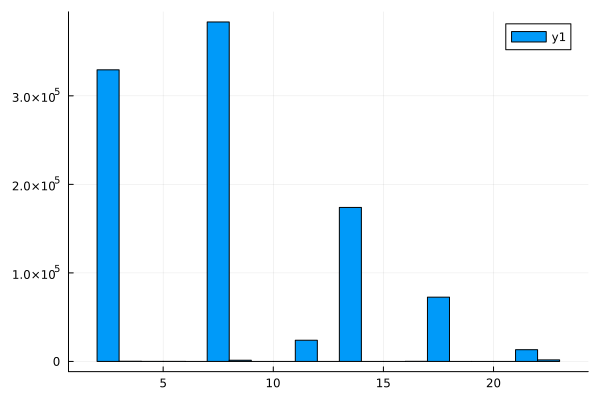

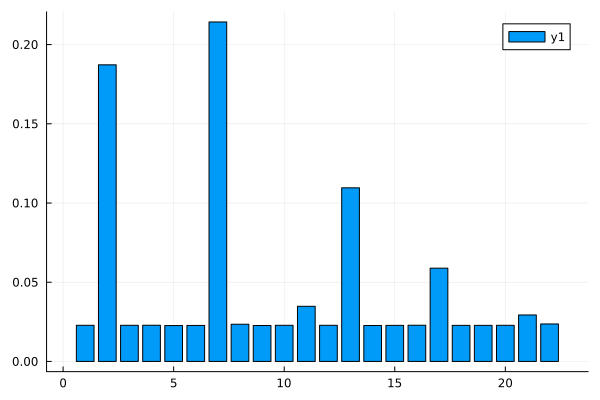

In [46]:
display(histogram(sampleC, bins=I-1))
display(bar(mean(sampleD, dims=1)', bins=I-1))

predY = mean(Ysamples, dims=1)'
errUp = zeros(T)
errDown = zeros(T)
for t ∈ 1:T
    errUp[t] = quantile(Ysamples[:, t], 0.75)
    errDown[t] =  quantile(Ysamples[:, t], 0.25)
end

In [47]:
panel = load_brexit_panel()
s = SimpleSCM(panel)
SynthControl.fit!(s)


Synthetic Control Model

Treatment panel:
	Model is fitted
	Impact estimates: [-0.54, -0.31, -0.206, -0.732, -1.241, -1.482, -1.818, -2.327, -1.994]


Balanced Panel - single treated unit, continuous treatment
    Treated unit: United Kingdom
    Number of untreated units: 22
    First treatment period: 2016-07-01
    Number of pretreatment periods: 30
    Number of treatment periods: 9


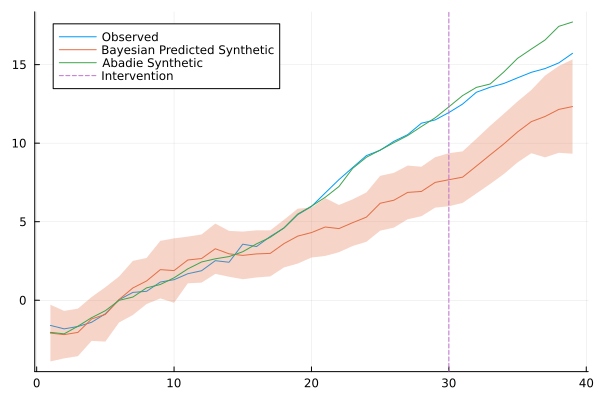

In [48]:
plot(Y, label="Observed")
#plot!(sum(mean(sampleD, dims=1)' .* X, dims=1)', label="Bayesian Synthetic")
#plot!(sum(sampleD[6, :] .* X, dims=1)', label="Single Sample Bayesian Synthetic")
plot!(predY, ribbon=errUp - errDown, fillalpha=.3, label="Bayesian Predicted Synthetic")

plot!(s.ŷ₁, label="Abadie Synthetic")
plot!([ObsT], label="Intervention", seriestype = :vline, line=:dash)